# Chapter 12 用TensorFlow定制模型和训练

## Setup

In [1]:
# This project requires Python 3.7 or above:

import sys

assert sys.version_info >= (3, 7)

In [2]:
# TensorFlow ≥ 2.8:

from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

到目前为止，我们只使用了TensorFlow的高级API Keras，但它已经让我们走得很远：我们构建了各种神经网络架构，包括回归和分类网、宽网和深网，以及自标准化网，使用各种技术，如批标准化、辍学和学习率时间表。事实上，您将遇到的95%的用例只需要Keras（和tf.data；参见第13章）。但现在是时候深入研究TensorFlow，看看它的底层Python API了。当您需要额外的控件来编写自定义损失函数、自定义度量值、图层、模型、初始化器、正则化器、权重约束等时，这将非常有用。您甚至可能需要完全控制训练循环本身；例如，对梯度应用特殊的转换或约束（而不仅仅是裁减它们），或者对网络的不同部分使用多个优化器。我们将在本章中介绍所有这些情况，并且我们还将讨论如何使用TensorFlow的自动图生成特性来增强您的自定义模型和训练算法。但首先，让我们快速参观一下TensorFlow。

## 1. 快速游览一下TensorFlow

TensorFlow是一个强大的数值计算库，它非常适合和微调了大规模的机器学习（但你可以把它用于任何其他需要大量计算的事情）。它是由谷歌Brain团队开发的，它支持谷歌的许多大规模服务，如谷歌云语音、谷歌照片和谷歌搜索。无数的项目将TensorFlow用于各种机器学习任务，如图像分类、自然语言处理、推荐系统和时间序列预测。

**TensorFlow能提供的内容**：

1. 它的内核与NumPy非常相似，但是支持GPU。
2. 它支持分布式计算（跨多个设备和服务器）。
3. 它包括一种即时（just-in-time，JIT）编译器，允许它优化计算的速度和内存使用量。它的工作原理是从一个Python函数中提取计算图，优化它（例如，通过修剪未使用的节点），并有效地运行它（例如，通过自动并行地运行独立的操作）。
4. 计算图可以导出为可移植格式，因此您可以在一个环境中训练TensorFlow模型（例如，在Linux上使用Python），并在另一个环境中运行它（例如，在Android设备上使用Java）。
5. 它实现了反向模式的自动分割（见第10章和附录B），并提供了一些优秀的优化器，如RMSProp和Nadam（见第11章），因此您可以轻松地最小化各种损失函数。

**TensorFlow 的 Python API**：

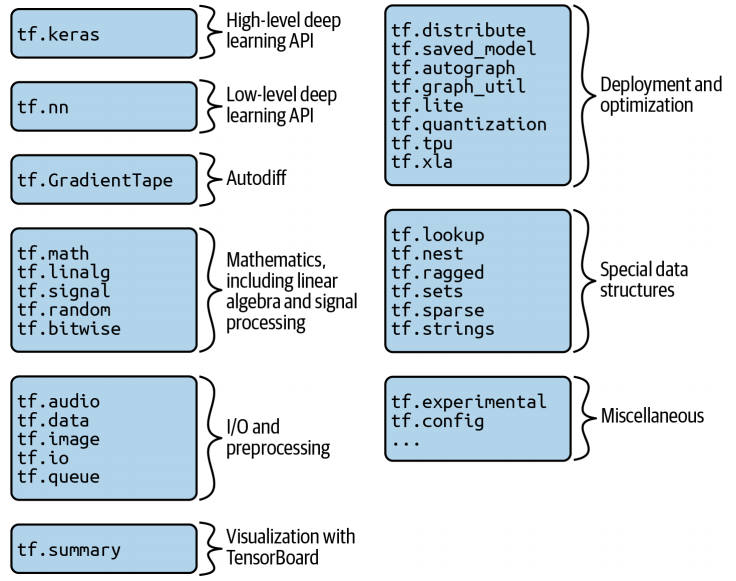

**TensorFlow 架构**：

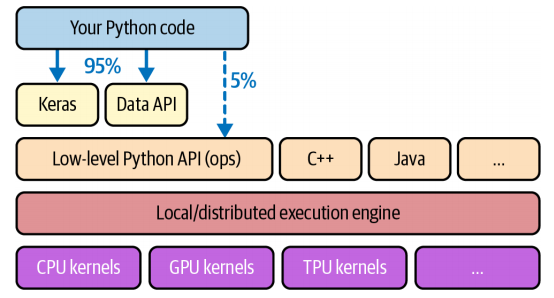

## 2. 像NumPy一样使用TensorFlow

TensorFlow的API围绕着**tensors**，tensors从操作flow到操作，因此被称为“TensorFlow”。一个tensor与NumPy ndarray非常相似：它通常是一个多维数组，但它也可以包含一个标量（一个简单的值，如42）。当我们创建自定义成本函数、自定义度量、自定义层等时，这些tensors将非常重要，所以让我们看看如何创建和操作它们。

### 2.1 张量和操作（Tensors and Operations）

你可以用tf.constant()创建一个张量。

例如，这里有一个张量，表示一个有两行和三列浮点数的矩阵：

In [3]:
import tensorflow as tf

t = tf.constant([[1., 2., 3.], [4., 5., 6.]]) # matrix

t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [4]:
# tf.Tensor has a shape and a data type (dtype)

t.shape

TensorShape([2, 3])

In [5]:
t.dtype

tf.float32

In [6]:
# Indexing works much like in NumPy

t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [7]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

In [8]:
# all sorts of tensor operations are available

t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [9]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [10]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

In [11]:
# A tensor can also hold a scalar value

tf.constant(42)

<tf.Tensor: shape=(), dtype=int32, numpy=42>

## 2.2 Tensors 与 NumPy（Tensors and NumPy）

Tensors与NumPy很好：你可以从NumPy数组创建一个tensor，反之亦然。您甚至可以对NumPy数组和NumPy操作应用TensorFlow操作：

In [14]:
import numpy as np

In [15]:
 a = np.array([2., 4., 5.])

In [16]:
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [17]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [18]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [19]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

请注意，NumPy默认使用64位精度，而TensorFlow则使用32位精度。这是因为32位的精度对于神经网络来说通常已经足够了，而且它运行得更快，使用的内存也更少。因此，当你从一个NumPy数组创建一个Tensor时，请确保设置dtype=tf.float32。

### 2.3 类型转换（Type Conversions）

类型转换会严重影响性能，当它们自动完成时，它们很难被注意到。为了避免这种情况，TensorFlow不会自动执行任何类型转换：如果您尝试对具有不兼容类型的张量执行操作，它只会引发一个异常。例如，您不能添加浮点张量和整数张量，甚至不能执行32位浮点和64位浮点的加法：

In [20]:
tf.constant(2.) + tf.constant(40)

InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2]

In [21]:
tf.constant(2.) + tf.constant(40., dtype=tf.float64)

InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2]

一开始可能有点烦人，但请记住这是一个好的理由！当然，当你真的需要转换类型时，你也可以使用 **tf.cast()** ：

In [22]:
t2 = tf.constant(40., dtype=tf.float64)

tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

### 2.4 变量（Variables）

我们到目前为止所看到的 **tf.Tensor** 值是不可改变的：我们不能修改它们。这意味着我们不能在神经网络中使用规则张量实现权值，因为它们需要通过反向传播进行调整。此外，其他参数也可能需要随着时间的变化（例如，动量优化器跟踪过去的梯度）。我们需要的是一个 **tf.Variable** ：

In [24]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])

v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

一个 **tf.Variable** 的作用很像一个 **tf.Tensor**：你可以用它执行相同的操作，它也和NumPy结合得很好，而且它对类型也同样挑剔。但是它也可以使用 **assign()** 方法（或 **assign_add()** 或 **assign_sub()** ，使变量增加或减少）。您还可以通过使用单元格（或切片） **assign()** 方法或使用 **scatter_update()** 方法或 **scatter_nd_update()** 方法修改单个单元格（或切片）：

In [25]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [26]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [27]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [28]:
v.scatter_nd_update(indices=[[0, 0], [1, 2]], updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

**直接赋值不起作用**：

In [29]:
v[1] = [7., 8., 9.]

TypeError: 'ResourceVariable' object does not support item assignment

在实践中，很少需要手动创建变量；Keras提供了一个 **add_weight()** 方法，它将为您处理它。此外，模型参数通常会由优化器直接更新，因此您很少需要手动更新可变量。

### 2.5 其他数据结构（Other Data Structures）

TensorFlow还支持其他几种数据结构，包括以下内容（详情请参见本章笔记本或附录C中的“其他数据结构”部分）：

1. **稀疏张量（tf.SparseTensor）**：有效地表示包含大部分为零的张量。**tf.sparse** package包含对稀疏张量的运算。
2. **张量数组（tf.TensorArray）**：是张量的列表。默认情况下，它们有一个固定的长度，但可以选择其可扩展。它们所包含的所有张量都必须具有相同的形状和数据类型。
3. **不规则张量（tf.RaggedTensor）**：表示所有秩和数据类型相同的张量列表，但大小不同。张量大小变化的维度被称为不规则维度。**tf.ragged** package包含对粗糙张量的操作。
4. **字符串张量（String tensors）**：是 **tf.strint** 类型的规则张量。这些表示字节字符串，而不是Unicode字符串，所以如果您使用Unicode字符串创建字符串张量（例如，常规Python 3字符串，如“cafe”），那么它将被自动编码为UTF-8（例如，b“caf\xc3\xa9”）。或者，您可以使用 **tf.int32** 类型的张量来表示Unicode字符串，其中每个项表示一个Unicode代码点（例如，\[99,97,102,233\]）。**tf.strings** package（用s表示）包含字节字符串和Unicode字符串的操作（并将其中一个转换为另一个）。需要注意的是，tf.string是原子的，这意味着它的长度不会出现在张量的形状中。一旦你把它转换为一个Unicode张量（即，一个包含tf.int32类型的张量），长度就会以形状出现。
5. **集合（Sets）**：被表示为正则张量（或稀疏张量）。例如，tf.constant(\[\[1, 2], \[3, 4\]\])表示这两个集合{1,2}和{3,4}。更一般地，每个集合用张量最后一个轴上的一个向量表示。您可以使用 **tf.sets** 软件包中的操作来操作集。
6. **队列（Queues）**：跨多个步骤存储张量。TensorFlow提供了各种队列：基本的先入先出（FIFO）队列（FIFOQueue），加上可以预先项目的队列（优先队列），洗牌其项目（随机洗牌队列），以及通过填充不同形状的批处理项目（填充FIFOQueue）。这些类都在 **tf.queue** 包中。

## 3. 定制模型和训练算法（Customizing Models and Training Algorithms）

您将首先创建一个自定义损失函数，这是一个简单通用的用例。

### 3.1 自定义损失函数（Custom Loss Functions）

假设你想训练一个回归模型，但是你的训练集有点嘈杂。当然，您首先尝试通过删除或修复异常值来清理数据集，但结果证明这是不够的；数据集仍然有噪声。您应该使用哪个损失函数？均方误差可能会惩罚太大的误差，并导致您的模型不精确。平均绝对误差不会对异常值造成太多的惩罚，但训练可能需要一段时间才能收敛，而且训练后的模型可能不是很精确。这可能是使用Huber损失（在第10章中介绍）而不是好的旧的MSE的好时机。

Huber损失可以在Keras中找到(只需使用tf.keras.losses的一个实例。但让我们假装它不在那里。要实现它，只需创建一个函数，将标签和模型的预测作为参数，并使用张量流操作来计算一个包含所有损失的张量（每个样本一个）：

In [30]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

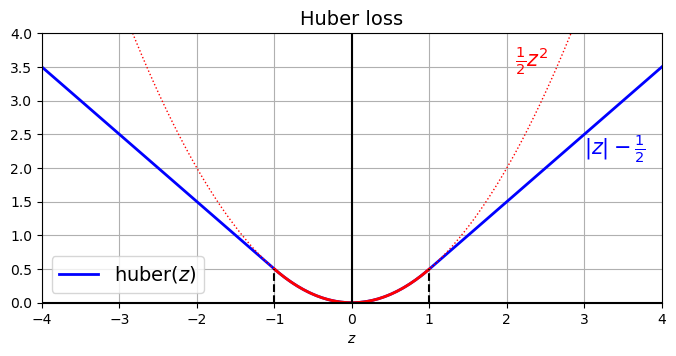

In [31]:
# shows what the Huber loss looks like

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
z_center = np.linspace(-1, 1, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z ** 2 / 2, "r:", linewidth=1)
plt.plot(z_center, z_center ** 2 / 2, "r", linewidth=2)
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "k--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "k--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.text(2.1, 3.5, r"$\frac{1}{2}z^2$", color="r", fontsize=15)
plt.text(3.0, 2.2, r"$|z| - \frac{1}{2}$", color="b", fontsize=15)
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

为了获得更好的性能，您应该使用向量化的实现，如本例中所示。此外，如果您想从TensorFlow的图优化特性中获益，那么您应该只使用TensorFlow操作。

也可以返回平均损失而不是单个样本损失，但不建议这样做，因为它使得不可能在需要时使用类权重或样本权重（参见第10章）。

现在您可以在编译Keras模型时使用Huber损失函数，然后像往常一样训练你的模型：

In [40]:
# loads, splits and scales the California housing dataset
# then creates a simple Keras model

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

input_shape = X_train.shape[1:]

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", 
                          kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [33]:
model.compile(loss=huber_fn, 
              optimizer="nadam",
              metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.4810 - mae: 0.8349 - val_loss: 0.2892 - val_mae: 0.6041
Epoch 2/2
363/363 [==============================] - 0s 953us/step - loss: 0.2574 - mae: 0.5627 - val_loss: 0.2124 - val_mae: 0.5006


就这样对于每批在训练期间，Keras将调用 huber_fn() 函数计算损失，然后它将使用反向模式自动分割计算损失的梯度对所有模型参数，最后它将执行梯度下降步骤（在这个例子中使用Nadam优化器）。此外，它还会跟踪自该epoch开始以来的总损失，并将显示平均损失。

### 3.2 保存和加载包含自定义组件的模型（Saving and Loading Models That Contain Custom Components）

保存包含自定义丢失函数的模型工作良好，但当您加载它时，您需要提供一个将函数名映射到实际函数的字典。更一般地说，在加载包含自定义对象的模型时，需要将名称映射到以下对象：

In [34]:
# saving works fine

model.save("my_model_with_a_custom_loss")  

INFO:tensorflow:Assets written to: my_model_with_a_custom_loss\assets


In [35]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss",
                                   custom_objects={"huber_fn": huber_fn})

In [36]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2094 - mae: 0.4965 - val_loss: 0.1828 - val_mae: 0.4565
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.1906 - mae: 0.4699 - val_loss: 0.1908 - val_mae: 0.4659


如果你在 **@keras.utils.register_keras_serializable()** 中使用 **huber_fn()** 函数，它将自动可用于 **load_model()** 函数：不需要将它包含在 **custom_objects** 字典中。

对于当前的实现，在-1和1之间的任何错误都被认为是“小的”。但如果你想要一个不同的阈值呢？一种解决方案是创建一个函数来创建一个已配置的损失函数：

In [39]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss = threshold * tf.abs(error) - threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

model.compile(loss=create_huber(2.0), 
              optimizer="nadam", 
              metrics=["mae"])

不幸的是，在保存该模型时，将不会保存该阈值。这意味着您在加载模型时必须指定阈值（注意，要使用的名称是“**huber_fn**”，这是您提供给Keras的函数的名称，而不是创建它的函数的名称）：

In [40]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2072 - mae: 0.4637 - val_loss: 0.1945 - val_mae: 0.4426
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2000 - mae: 0.4563 - val_loss: 0.1879 - val_mae: 0.4450


In [41]:
model.save("my_model_with_a_custom_loss_threshold_2")

INFO:tensorflow:Assets written to: my_model_with_a_custom_loss_threshold_2\assets


In [42]:
model = tf.keras.models.load_model(
    "my_model_with_a_custom_loss_threshold_2",
    custom_objects={"huber_fn": create_huber(2.0)})

In [43]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.1952 - mae: 0.4508 - val_loss: 0.1788 - val_mae: 0.4305
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.1909 - mae: 0.4450 - val_loss: 0.2003 - val_mae: 0.4467


可以通过创建 **tf.keras.losses.Loss** 的一个子类来解决这个问题，然后实现其 **get_config()** 方法：

In [44]:
class HuberLoss(tf.keras.losses.Loss):
    
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
        
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

**对于代码的解释**：

1. 构造函数接受 **\*\*kwargs** 并将它们传递给父构造函数，父构造函数处理标准的超参数：损失的 **name** 和用于聚合单个实例损失的缩减算法。默认情况下，这是“**AUTO**”，相当于“SUM_OVER_BATCH_SIZE”：损失将是实例损失的总和，加权样本权重，如果有的话，并除以批大小（不是权重的和，所以这不是加权平均值）。其他可能的值是“SUM”和“NONE”。
2. **call()** 方法获取标签和预测，计算所有的实例损失，并返回它们。
3. **get_config()** 方法返回一个将每个超参数名称映射到其值的字典。它首先调用父类的get_config（）方法，然后将新的超参数添加到这个字典中。

In [45]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu",
                          kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

model.compile(loss=HuberLoss(2.), 
              optimizer="nadam", 
              metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.7356 - mae: 0.9203 - val_loss: 0.4701 - val_mae: 0.6782
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2962 - mae: 0.5704 - val_loss: 0.2762 - val_mae: 0.5247


In [46]:
model.save("my_model_with_a_custom_loss_class") 

INFO:tensorflow:Assets written to: my_model_with_a_custom_loss_class\assets


In [47]:
model = tf.keras.models.load_model(
    "my_model_with_a_custom_loss_class",
    custom_objects={"HuberLoss": HuberLoss})

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2275 - mae: 0.4940 - val_loss: 0.2095 - val_mae: 0.4590
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2021 - mae: 0.4620 - val_loss: 0.1905 - val_mae: 0.4468


In [48]:
model.loss.threshold

2.0

### 3.3 自定义激活函数、初始化器、正则化器和约束条件

大多数Keras功能，如损失（**loss**）、正则化器（**regularizers**）、约束（**constraints**）、初始化器（**initializers**）、指标（**metrics**）、激活函数（**activation function**）、层（**layers**），甚至完整的模型，都可以以几乎相同的方式进行定制。大多数情况下，您只需要编写一个带有适当的输入和输出的简单函数。

这里有一个自定义激活功能的例子（相当于 tf.keras.activations.softplus() 或 tf.nn.softplus() ），一个自定义Glorot初始化器（相当于tf.keras.initializers.glorot_normal()），一个自定义 $ℓ_1$ 正则化器（相当于 tf.keras.regularizers.l1(0.01) ），和一个确保权重都是正的自定义约束(相当于 tf.keras.constraints.nonneg() 或 tf.nn.relu() )：

In [49]:
def my_softplus(z):
    return tf.math.log(1.0 + tf.exp(z))

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

如您所看到的，这些参数取决于自定义函数的类型。这些自定义函数可以正常使用，如下所示：

In [50]:
layer = tf.keras.layers.Dense(1, activation=my_softplus,
                              kernel_initializer=my_glorot_initializer,
                              kernel_regularizer=my_l1_regularizer,
                              kernel_constraint=my_positive_weights)

激活函数将被应用于这个密集层的输出，其结果将被传递到下一层。图层的权重将使用初始化器返回的值进行初始化。在每个训练步骤中，权值将被传递给正则化函数来计算正则化损失，并将其加到主要损失中，得到用于训练的最终损失。最后，约束函数将在每个训练步骤后调用，层的权值将被约束的权值取代。

如果一个函数具有需要与模型一起保存的超参数，那么您将希望对适当的类进行子类化，例如tf.keras.regularizers.Regularizer，tf.keras.constraints.Constraint，tf.keras.initializers.Initializer或tf.keras.layers.Layer（适用于任何层，包括激活函数）。就像您对自定义丢失所做的一样，这里有一个简单的 $ℓ_1$ 正则化类，用于保存它的因子超参数（这次您不需要调用父构造函数或get_config()方法，因为它们不是由父类定义的）：

In [51]:
class MyL1Regularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    
    def get_config(self):
        return {"factor": self.factor}

请注意，您必须为loss、layers（包括激活函数）和models实现 call() 方法，或者为regularizers、initializers和constraints实现\_\_call\_\_()方法。对于metrics，情况有点不同，正如您现在将看到的那样。

### 3.4 自定义度量（Custom Metrics）

损失和度量标准在概念上是不一样的：损失（例如，交叉熵）被梯度下降用来训练一个模型，所以它们必须是可微的（至少在评估它们的点上），而且它们的梯度不应该到处都是零。另外，如果它们不容易被人类解释也没关系。相比之下，度量标准（例如，准确性）被用来评估一个模型：它们必须更容易解释，并且它们可以是不可微的，或者到处都是零梯度。

也就是说，在大多数情况下，定义自定义度量函数与定义自定义损失函数完全相同。事实上，我们甚至可以使用我们之前创建的Huber损失函数作为度量；它会工作得很好（持久性也会以同样的方式工作，在这种情况下只保存函数的名称“huber_fn”，而不是阈值）：

In [52]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

对于训练期间的每一批，Keras将计算这个度量，并跟踪其从epoch开始以来的平均值。大多数时候，这正是你想要的。但并不总是如此！

例如，考虑一个二分类器的精度。正如你在第三章中看到的，精度是真阳性的数量除以阳性预测的数量（包括真阳性和假阳性）。假设模型在第一批中做出了5个积极的预测，其中4个是正确的：80%的精度。然后假设模型在第二批中做出了三个积极的预测，但它们都是不正确的：对于第二批的精度为0%。如果你只计算这两个精度的平均值，你就会得到40%。但是等一下——这不是模型对这两批产品的精度！事实上，在8个阳性预测（5个+ 3）中，共有4个真阳性（4个+ 0），所以总体精度是50%，而不是40%。我们需要的是一个对象，它可以跟踪真阳性的数量和假阳性的数量，并可以在请求时基于这些数字计算精度。这正是 **tf.keras.metrics.Precision** 所做的

In [53]:
precision = tf.keras.metrics.Precision()

In [54]:
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [55]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

在这个例子中，我们创建了一个Precision对象，然后像使用函数一样使用它，传递给第一批的标签和预测，然后传递给第二批（如果需要的话，您也可以选择传递样本权重）。我们使用了与我们刚才讨论的例子中相同数量的真阳性和假阳性。第一批后返回80%，第二批后返回50%（这是目前的整体精度，而不是第二批的精度）。这被称为流度量**streaming metric**（或状态度量**stateful metric**），因为它逐批逐步更新。

在任何时候，我们都可以调用 **result()** 方法来得到度量的当前值。我们也可以通过使用 **variables** 属性来查看它的变量（跟踪真阳性的数量），我们可以使用 **reset_states()** 方法重置这些变量：

In [56]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [57]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [58]:
# both variables get reset to 0.0

precision.reset_states()

In [59]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [60]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

如果需要定义自己的自定义流度量，请创建 **tf.keras.metrics.Metric** 的子类。

这里是一个基本的例子，跟踪总Huber损失和目前看到的实例数量。当被问到结果时，它返回这个比率，这只是平均Huber损失：

In [61]:
class HuberMetric(tf.keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
 
    def update_state(self, y_true, y_pred, sample_weight=None):
        sample_metrics = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(sample_metrics))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
 
    def result(self):
        return self.total / self.count
 
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

**代码说明**：

1. 构造函数使用 **add_weight()** 方法来创建在多个批上跟踪度量状态所需的变量——在这种情况下，是所有Huber损失的总和（总数）和迄今为止看到的实例数（计数）。如果您愿意，您可以手动创建变量。Keras跟踪任何设置为属性的tf.Variable（更一般地说，是任何“可跟踪”对象，如层或模型）。
2. 当您将此类的实例作为函数使用时，将调用 **update_state()** 方法。它更新变量，给定一批处理的标签和预测（以及样本权重，但在这种情况下，我们忽略它们）。
3. **result()** 方法计算并返回最终结果，在这种情况下是所有实例的平均Huber度量。当您使用度量作为函数时，将首先调用 **update_state()** 方法，然后调用 **result()** 方法，并返回其输出。
4. 我们还实现了 **get_config()** 方法，以确保阈值与模型一起保存。
5. **reset_states()** 方法的默认实现会将所有变量重置为0.0（但如果需要，您可以覆盖它）。

当您使用一个简单的函数定义一个度量时，Keras会自动为每个批处理调用它，并且它会跟踪每个epoch的平均值，就像我们手动做的那样。所以我们的HuberMetric类的唯一好处是阈值将被保存。但是当然，一些指标，比如精度，不能简单地在批上平均：在这种情况下，除了实现流度量，没有其他选择。现在您已经建立了一个流度量，构建一个自定义层就像在公园里散步！

### 3.5 自定义层（Custom Layers）

您可能偶尔希望构建一个包含TensorFlow不提供默认实现的外来层的体系结构。或者，您可能只是想构建一个非常重复的体系结构，其中特定的层块重复多次，将每个块作为单个层会很方便。对于这种情况，您将希望构建一个自定义层。

有些图层没有权重，比如 **tf.keras.layers.Flatten** 或 **tf.keras.layers.ReLU** 。如果您想创建一个没有任何权重的自定义图层，最简单的选择是编写一个函数并将其包装在一个 **tf.keras.layers.Lambda layer** 。

例如，下一层将把该指数函数应用于其输入端：

In [62]:
exponential_layer = tf.keras.layers.Lambda(lambda x: tf.exp(x))

然后可以像任何其他层一样使用顺序API、功能API或子类化API。您也可以使用它作为激活函数，也可以使用 **activation=tf.exp** 。当预测的值具有非常不同的尺度（例如，0.001,10.，1000.）时，回归模型的输出层有时使用指数层。事实上，指数函数是Keras中的标准激活函数之一，所以你可以只使用 **activation="exponential"** 。

正如您可能猜测的那样，要构建自定义有状态层（即，带有权重的层），您需要创建 **tf.keras.layers.Layer** 类的子类。例如，下面的类实现了密集层的简化版本：

In [63]:
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", 
            shape=[batch_input_shape[-1], self.units],
            initializer="he_normal")
        self.bias = self.add_weight(
            name="bias", 
            shape=[self.units], 
            initializer="zeros")
        super().build(batch_input_shape)  # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": tf.keras.activations.serialize(self.activation)}

**代码解释**：

1. 构造函数将所有超参数作为参数（在本例中，**units** 和 **activation**），重要的是，它还接受一个 **\*\*kwargs** 参数。它调用父构造函数，并将其传递为 **kwargs** ：这将处理标准参数，如input_shape、trainable和name。然后，它将超参数保存为属性，使用 **tf.keras.activations.get()** 函数将 **activation** 参数转换为适当的激活函数（它接受函数，标准字符串，如“relu”或“swish”，或简单的None）。
2. **build()** 方法的角色是通过为每个权重调用 **add_weight()** 方法来创建层的变量。在第一次使用该层时，将被调用 **build()** 方法。在这时，Keras将知道这个层输入的形状，并将其传递给 **build()** 方法，这通常是创建一些权重所必需的。例如，我们需要知道前一层的神经元数量，以便创建连接权值矩阵（即“**kernel**”）：这对应于输入的最后一个维度的大小。在 **build()** 方法的末尾（并且仅在末尾），您必须调用父级的 **build()** 方法：这告诉Keras该层已经构建（它只是设置 **self.built = True** ）。
3. **call()** 方法将执行所需的操作。在这种情况下，我们计算输入X和该层的kernel的矩阵乘法，我们加上偏置向量，然后我们将激活函数应用于结果，这就给出了该层的输出。
4. **get_config()** 方法就像在前面的自定义类中一样。请注意，我们通过调用 **tf.keras.activations.serialize()** 来保存激活函数的完整配置。

Keras会自动推断输出形状，除非图层是动态的（您很快就会看到）。在这种（罕见的）情况下，您需要实现 **compute_output_shape()** 方法，该方法必须返回一个 **TensorShape** 对象。

您现在可以像其他任何层一样使用MyDense层了！

要创建一个具有多个输入（例如 **Concatenate** ）的层，**call()** 方法的参数应该是一个包含所有输入的元组。要创建具有多个输出的层，**call()** 方法应该返回输出列表。

例如，下面的玩toy层接受两个输入并返回三个输出：

In [64]:
class MyMultiLayer(tf.keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape)  # extra code
        return X1 + X2, X1 * X2, X1 / X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape1, batch_input_shape1]

这个层现在可以像任何其他层一样使用，但当然只使用函数和子类化API，而不是顺序API（它只接受有一个输入和一个输出的层）。

如果您的图层在训练期间和测试期间需要有不同的行为（例如，如果它使用 **Dropout** 层或 **BatchNormalization** 层），那么您必须向 **call()** 方法添加一个 **training** 参数，并使用这个参数来决定要做什么。

例如，让我们创建一个层，它在训练过程中添加高斯噪声（用于正则化），但在测试过程中什么都不做(Keras有一个层 **tf.keras.layers.GaussianNoise** 可以做同样的事情）：

In [65]:
class MyGaussianNoise(tf.keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

有了它，您现在就可以构建任何您需要的自定义层了！现在让我们来看看如何创建自定义模型。

### 3.6 自定义模型（Custom Models）

在我们讨论的第10章中，我们已经考虑了创建自定义模型类。这很简单： **tf.keras.Model** 的子类，在构造函数中创建图层和变量，并实现 **call()** 方法来做您希望模型做的任何事情。

例如，假设我们想要构建图中所示的模型。

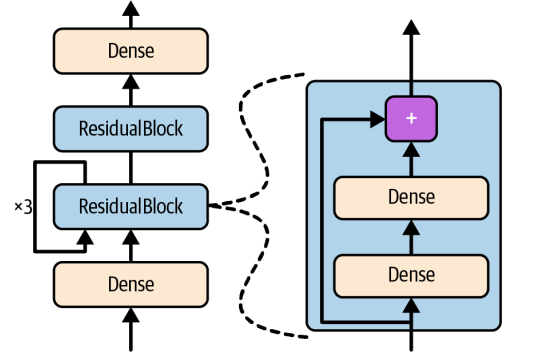

输入通过第一个密集层，然后通过一个由两个密集层和一个附加操作组成的残差块(正如你将在第14章中看到的，一个残差块将其输入添加到其输出)，然后再通过这个相同的残块三次，然后通过第二个残块，最终结果通过一个密集的输出层。如果这个模型没有太大意义，不要担心；它只是一个例子来说明您可以轻松地构建任何类型的模型，即使是包含循环和跳过连接的模型。为了实现这个模型，最好首先创建一个残差块层，因为我们将创建几个相同的块（我们可能想在另一个模型中重用它）：

In [66]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [tf.keras.layers.Dense(n_neurons, 
                                             activation="relu",
                                             kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

这个层有点特殊，因为它包含其他层。这是由Keras透明地处理的：它会自动检测到 **hidden** 属性包含可跟踪的对象（在这种情况下是层），因此它们的变量会自动添加到该层的变量列表中。这个class的其余部分都是不言自明的。接下来，让我们使用子类化API来定义模型本身：

In [67]:
class ResidualRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = tf.keras.layers.Dense(30,
                                             activation="relu",
                                             kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

我们在构造函数中创建图层，并在 **call()** 方法中使用它们。然后，这个模型可以像任何其他模型一样使用（编译它、拟合它、评估它，并使用它来进行预测）。如果您还想能够使用 **save()** 方法保存模型并使用 **tf.keras.models.load_model()** 函数加载它，那么您必须在两个残差块类和残差回归类中实现 **get_config()** 方法（正如我们之前所做的那样）。或者，您可以使用 **save_weights()** 和 **load_weights()** 方法来保存和加载权重。

**Model类** 是 **Layer类** 的一个子类，因此可以完全像层一样定义和使用moedel。但模型有一些额外的功能，当然包括 **compile()**，**fit()**，**evaluate()**，**predict()** 方法（和一些变体），加上 **get_layer()** 方法（可以返回任何模型的层的名称或索引）和 **save()** 方法（支持 **tf.keras.models.load_model()** 和 **tf.keras.models.clone_model()** ）。

**如果模型比层提供更多的功能，为什么不将每个层定义为模型呢？** 

从技术上讲，你可以，但是区分模型的内部组件（即层或可重用的层块）与模型本身（即你将训练的对象区分开来）通常更简洁。前者应该对Layer类进行子类化，而后者应该对Model类进行子类化。

有了它，您就可以自然而简洁地构建您在论文中找到的几乎任何模型，使用顺序API、函数API、子类化API，甚至是它们的混合。“几乎”有任何模型吗？是的，我们还有一些事情需要考虑：首先，如何基于模型内部结构来定义损失或指标，其次，如何构建一个自定义的训练循环。

### 3.7 基于模型内部结构的损失和度量标准（Losses and Metrics Based on Model Internals）

我们之前定义的自定义损失和指标都是基于标签和预测（以及可选的样本权重）。有时，您会希望根据模型的其他部分来定义损失，例如其隐藏层的权重或激活情况。这可能对正则化目的或监视模型的某些内部方面很有用。

要定义基于模型内部的自定义损失，根据您想要的模型的任何部分计算它，然后将结果传递给 **add_loss()** 方法。

例如，让我们构建一个自定义回归MLP模型，由五个隐藏层和一个输出层组成。这个自定义模型还将在上隐藏层的顶部有一个辅助输出。与此辅助输出相关的损失将被称为**重构损失 reconstruction loss**（见第17章）：它是重构和输入之间的均方差。通过将这个重构损失添加到主要损失中，我们将鼓励模型通过隐藏层保存尽可能多的信息——甚至是对回归任务本身没有直接有用的信息。在实践中，这种损失有时会提高泛化效果（这是一种正则化损失）。也可以使用模型的 **add_metric()** 添方法加一个自定义度量。

下面是这个具有自定义重建损失和自定义相应度量的自定义模型的代码：

In [68]:
class ReconstructingRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [tf.keras.layers.Dense(30, activation="relu",
                                             kernel_initializer="he_normal")
                       for _ in range(5)]
        self.out = tf.keras.layers.Dense(output_dim)
        self.reconstruction_mean = tf.keras.metrics.Mean(
            name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = tf.keras.layers.Dense(n_inputs)
        self.built = True  # WORKAROUND for super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z)

**代码解释**：

1. 构造函数创建具有五个密集隐藏层和一个密集输出层的DNN。我们还创建了一个 Mean 流度量来跟踪训练期间的重构误差。
2. **build()** 方法创建了一个额外密集的层，将用于重建模型的输入。它必须在这里创建，因为它的单位数必须等于输入的数量，并且在调用 **build()** 方法之前，这个数字是未知的。
3. **call()** 方法通过所有五个隐藏层处理输入，然后将结果通过重构层传递，从而产生重构。
4. 然后 **call()** 方法计算重建损失（重建和输入之间的均方差），并使用add_loss（）方法将其添加到模型损失列表。请注意，我们通过将重建损失乘以0.05（这是一个你可以调整的超参数）来缩小重建损失。这确保了重建损失不会主导主要损失。
5. 接下来，仅在训练期间，**call()** 方法更新重建度量并将其添加到模型中，以便显示。这个代码示例实际上可以通过调用 **self.add_metric(recon_loss)** 来简化： Keras将自动为您跟踪平均值。
6. 最后，**call()** 方法将隐藏层的输出传递给输出层，并返回其输出。

In [69]:
# extra code
tf.random.set_seed(42)
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
y_pred = model.predict(X_test_scaled)

Epoch 1/5
363/363 [==============================] - 2s 2ms/step - loss: 1.4217 - reconstruction_error: 1.1204
Epoch 2/5
363/363 [==============================] - 0s 910us/step - loss: 0.5071 - reconstruction_error: 0.6802
Epoch 3/5
363/363 [==============================] - 0s 876us/step - loss: 0.4633 - reconstruction_error: 0.5136
Epoch 4/5
363/363 [==============================] - 0s 883us/step - loss: 0.4081 - reconstruction_error: 0.4685
Epoch 5/5
162/162 [==============================] - 0s 596us/step


在大多数情况下，到目前为止，我们所讨论的所有内容都足以实现您想要构建的任何模型，即使是使用复杂的架构、损失和度量标准。但是，对于某些架构，如GANs（参见第17章），您将必须自定义训练循环本身。在我们到达那里之前，我们必须看看如何在张量流中自动计算梯度。

### 3.8 使用Autodiff计算梯度（Computing Gradients Using Autodiff）

要了解如何使用自动分割（参见第10章和附录B）来自动计算梯度，让我们考虑一个简单的toy函数：

In [12]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

如果你知道微积分，你可以分析发现这个函数关于 $w1$ 的偏导数是 $6*w1+2*w2$ 。你还可以发现它对 $w2$ 的偏导数是 $2*w1$ 。

例如，在点 $(w1,w2)=(5,3)$ 处，这些偏导数分别等于36和10，因此在该点处的梯度向量为（36,10）。但如果这是一个神经网络，函数将会复杂得多，通常有成千上万的参数，而手工解析找到偏导数将是一项几乎不可能的任务。一种解决方案可以是计算每个偏导数的近似，通过测量函数的输出变化多少，当你调整相应的参数很少：

In [13]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [14]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

看对了！这工作得很好，也很容易实现，但它只是一个近似值，重要的是，您需要在每个参数中至少调用f()一次（不是两次，因为我们可以只计算f（w1，w2）一次）。每个参数至少调用一次f（）使得这种方法对于大型神经网络来说难以处理。所以，我们应该使用反向模式的自动分割。TensorFlow 使这变得非常简单：

In [15]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)

with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

我们首先定义两个变量 $w1$ 和 $w2$ ，然后我们创建一个 tf.GradientTape ,它将自动记录每个涉及一个变量的操作，最后我们要求这个计算结果z关于这两个变量的梯度[w1，w2]。让我们来看看张量流计算出的梯度：

In [16]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

结果不仅是准确的（精度只受浮点误差的限制），而且 **gradient()** 方法只通过一次记录的计算（以相反的顺序），无论有多少个变量，所以它是非常有效的。这就像魔法！

为了节省内存，只在 **tf.GradientTape()** 中放上严格的最小值。或者，通过在 **tf.GradientTape()** 中创建一个 **tape.stop_recording()** 块来暂停记录。

**tape** 会在你调用它的 **gradient()** 方法后，立即被自动删除，所以如果你试图调用 **gradient()** 两次,你将得到一个异常：

In [17]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)  # returns tensor 36.0
try:
    dz_dw2 = tape.gradient(z, w2)  # raises a RuntimeError!
except RuntimeError as ex:
    print(ex)

A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


如果您需要多次调用 **gradient()** ，您必须使 tape 持久化，并在每次使用完时删除它来释放资源：

In [18]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)  # returns tensor 36.0
dz_dw2 = tape.gradient(z, w2)  # returns tensor 10.0, works fine now!
del tape

In [19]:
dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

默认情况下，tape 将只跟踪涉及变量的操作，因此，如果您尝试计算 z 对于变量以外的任何东西的梯度，结果将为 None ：

In [21]:
c1, c2 = tf.constant(5.), tf.constant(3.)

with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

gradients

[None, None]

然而，你可以强迫 tape 监视任何你喜欢的张量，记录涉及它们的每一个操作。然后你可以计算关于这些张量的梯度，就好像它们是变量一样：

In [22]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

这在某些情况下可能很有用，比如如果您想要实现正则化损失，当输入变化很小时，将惩罚变化很大的激活：损失将基于相对于输入的激活梯度。由于输入不是变量，所以您需要告诉磁带来监视它们。

大多数时候，梯度 tape 用于计算关于一组值（通常是模型参数）的单个值（通常是损失）的梯度。这就是反向模式的 Autodiff 有效的地方，因为它只需要做一个向前通过和一个反向通过，以在一次得到所有的梯度。如果您尝试计算一个向量的梯度，例如，一个包含多个损失的向量，则 TensorFlow 将计算该向量之和的梯度。因此，如果您需要获得单个的梯度（例如，每个损失与模型参数相关的梯度），您必须调用 tape 的 **jacobian()** 方法：它将对向量中的每个损失执行一次反向模式自动分割（默认情况下都是并行的）。甚至可以去计算二阶偏导数（黑森式，即偏导数的偏导数），但这在实践中很少需要。

In [23]:
# if given a vector, tape.gradient() will compute the gradient of the vector's sum.

with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [24]:
# shows that we get the same result as the previous cell
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)
    z = z1 + z2 + z3

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [25]:
# shows how to compute the jacobians and the hessians
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [26]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [27]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

在某些情况下，您可能希望阻止梯度通过神经网络的某些部分进行反向传播。为此，您必须使用 **tf.stop_gradient()** 函数。该函数在正向传递期间返回它的输入（如tf.identity()），但在反向传播期间，它不让梯度通过（它就像一个常数）：

In [28]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)  # same result as without stop_gradient()

gradients = tape.gradient(z, [w1, w2])

In [29]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

最后，在计算梯度时，可能会遇到一些数值问题。例如，如果你在 $x=10^{-50}$ 处计算平方根函数的梯度，结果将是无限的。实际上，这一点的斜率不是无限的，但它超过32位浮点可以处理：

In [30]:
x = tf.Variable(1e-50)
with tf.GradientTape() as tape:
    z = tf.sqrt(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=inf>]

为了解决这个问题，在计算 $x$ 的平方根时，给 $x$ 加一个小值（比如 $10^{-6}$ ）通常是一个好主意。

指数函数也是头痛的常见来源，因为它增长得非常快。例如，之前定义 **my_softplus()** 的方式不是数字上的。如果您计算 **my_softplus(100.0)** ，您将得到无穷大，而不是正确的结果（约100）。但可以重写函数使其数值稳定：softplus 函数被定义为 $log(1 + exp(z))$ ，也等于 $log(1 + exp(–|z|)) + max(z, 0)$ ，第二种形式的优势是指数项不能爆炸。所以，这里有一个更好的 **my_softplus()** 函数的实现：

In [31]:
def my_softplus(z):
    return tf.math.log(1 + tf.exp(-tf.abs(z))) + tf.maximum(0., z)

在一些罕见的情况下，一个数值上稳定的函数可能仍然具有数值上不稳定的梯度。在这种情况下，你将不得不告诉 TensorFlow 使用哪个方程的梯度，而不是让它使用自动分割。为此，在定义函数时必须使用 **@tf.custom_gradient** 解码器，并返回函数的结果和计算梯度的函数。例如，让我们更新 my_softplus() 函数，同时返回一个数值稳定的梯度函数：

In [33]:
@tf.custom_gradient
def my_softplus(z):
    def my_softplus_gradients(grads):  # grads = backprop'ed from upper layers
        return grads * (1 - 1 / (1 + tf.exp(z)))  # stable grads of softplus

    result = tf.math.log(1 + tf.exp(-tf.abs(z))) + tf.maximum(0., z)
    return result, my_softplus_gradients

In [34]:
# extra code – shows that the function is now stable, as well as its gradients
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>])

如果您知道微分运算，您可以发现 $log(1 + exp(z))$ 的导数是 $exp(z) / (1 + exp(z))$ 。但是这种形式并不稳定：对于较大的z值，它最终计算无穷除以无穷，从而返回NaN。但是，通过一些代数操作，您可以证明它也等于 $1 – 1 / (1 + exp(z))$ ，这是稳定的。 **my_softplus_gradients()** 函数使用这个方程来计算梯度。注意，这个函数将接收到目前为止反向传播的梯度，一直到 **my_softplus()** 函数，根据链式规则，我们必须将它们与这个函数的梯度相乘。

您现在可以计算任何函数的梯度（如果它在您计算它的地方是可微的），甚至在需要时阻止反向传播，并编写您自己的梯度函数！这可能比您所需要的更灵活，即使您构建了自己的自定义训练循环。接下来你会看看该怎么做的。

### 3.9 自定义训练循环（Custom Training Loops）

在某些情况下，**fit()** 方法可能不够灵活，不适合您需要做的事情。例如，我们在第10章中讨论的宽路径和深度论文使用了两种不同的优化器：一个用于宽路径，另一个用于深路径。由于 **fit()** 方法只使用了一个优化器（我们在编译模型时指定的那个优化器），因此实现本文需要编写您自己的自定义循环。

您可能还喜欢编写自定义训练循环，只是为了更自信地让他们做您想做的事情（也许您不确定 **fit()** 方法的一些细节）。有时，把一切都明确起来会感觉更安全。但是，请记住，编写自定义训练循环将使代码更长、更容易出错、更难维护。

除非你正在学习，或者你真的需要额外的灵活性，否则你应该更喜欢使用 **fit()** 方法，而不是实现你自己的训练循环，特别是如果你在一个团队中工作。

首先，让我们建立一个简单的模型。不需要编译它，因为我们将手动处理训练循环：

In [35]:
tf.random.set_seed(42)  # extra code – to ensure reproducibility

l2_reg = tf.keras.regularizers.l2(0.05)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="relu", 
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2_reg),
    tf.keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

接下来，让我们创建一个小函数，它将从训练集中随机抽取一批实例（在第13章中，我们将讨论 **tf.data** API，它提供了一个更好的替代方案）：

In [36]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

让我们还定义一个函数，它将显示训练状态，包括步数、总步数、自历元开始以来的平均损失（我们将使用平均度量来计算它），以及其他度量：

In [37]:
def print_status_bar(step, total, loss, metrics=None):
    metrics = " - ".join([f"{m.name}: {m.result():.4f}"
                          for m in [loss] + (metrics or [])])
    end = "" if step < total else "\n"
    print(f"\r{step}/{total} - " + metrics, end=end)

这段代码是不言自明的，除非您不熟悉Python字符串格式：{m.result():.4f}将度量的结果格式化为小数点后4位的浮数，并使用\r（回车）和end=""确保状态栏总是打印在同一行上。

首先，我们需要定义一些超参数，并选择优化器、损失函数和度量值（在本例中只有MAE）：

In [41]:
import numpy as np

np.random.seed(42)
tf.random.set_seed(42)

n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
mean_loss = tf.keras.metrics.Mean(name="mean_loss")
metrics = [tf.keras.metrics.MeanAbsoluteError()]

In [42]:
# build the custom loop

for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}")
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # extra code – if your model has variable constraints
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))

        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)

        print_status_bar(step, n_steps, mean_loss, metrics)

    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
362/362 - mean_loss: 1.1965 - mean_absolute_error: 0.6721
Epoch 2/5
362/362 - mean_loss: 0.5228 - mean_absolute_error: 0.5091
Epoch 3/5
362/362 - mean_loss: 0.4207 - mean_absolute_error: 0.4659
Epoch 4/5
362/362 - mean_loss: 0.4177 - mean_absolute_error: 0.4613
Epoch 5/5
362/362 - mean_loss: 0.4045 - mean_absolute_error: 0.4586


在每个时代的最后，我们重置平均损失和度量的状态在这段代码中发生了很多事情，所以让我们来浏览一下它：

1. 我们创建了两个嵌套的循环：一个用于epoch，另一个用于一个epoch内的batch。
2. 然后我们从训练集中随机抽取batch。
3. 在 **tf.GradientTape()** 块内部，我们使用模型作为函数对一个批进行预测，我们计算损失：它等于主损失加上其他损失（在这个模型中，每层有一个正则化损失）。由于 **mean_squared_error()** 函数每个实例返回一个损失，我们使用 **tf.reduce_mean()** 计算批处理的平均值（如果您想对每个实例应用不同的权重，您将这样做）。正则化损失已经减少到每个单个标量，所以我们只需要对它们求和（使用 **tf.add_n()** ，它对相同形状和数据类型的多个张量求和）。
4. 接下来，我们要求 tape 计算关于每个可训练变量的损失梯度——不是所有变量！-我们将它们应用于优化器以执行梯度下降步骤。
5. 然后，我们更新平均损失和度量标准（在当前时期内），并显示状态栏。
6. 在每个epoch的最后，我们重置平均损失和度量的状态。

如果要应用梯度切割（请参见第11章），请设置优化器的 **clipnorm** 或 **clipvalue** 超参数。如果您想对梯度应用任何其他转换，请在调用 **apply_gradients()** 方法之前这样做。如果您想向模型添加权重约束(例如，在创建图层时通过设置 **kernel_constraint** 或 **bias_constraint** )，您应该更新训练循环以在 **apply_gradients()** 之后应用这些约束，例如：

In [53]:
# extra code – shows how to use the tqdm package to display nice progress bars

from tqdm.notebook import trange
from collections import OrderedDict
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train_scaled, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)

                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))

                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()

                steps.set_postfix(status)

        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/362 [00:00<?, ?it/s]

当在训练循环中调用模型时，不要忘记设置 **training=True** ，特别是当您的模型在训练和测试期间行为不同时（例如，如果它使用批规格化或退出）。如果是自定义模型，请确保将训练参数传播到模型调用的图层。

正如你所看到的，有很多事情你需要做好，而且很容易犯错误。但从好的方面来看，你可以完全控制局面。现在你知道如何定制任何部分的模型和训练算法，让我们看看如何使用 TensorFlow 的自动图生成功能：它可以大大加快你的自定义代码，它也将使它可移植到任何平台支持的TensorFlow（见第19章）。

## 4. TensorFlow函数和图（TensorFlow Functions and Graphs）

回到TensorFlow 1中，图是不可避免的（以及它们所带来的复杂性），因为它们是TensorFlow API的中心部分。自从TensorFlow2（2019年发布）以来，图仍然存在，但不是那么中心，而且它们更简单。

为了说明多么简单，让我们从一个计算其输入的立方体的平凡函数开始：

In [54]:
def cube(x):
    return x ** 3

我们显然可以用Python值调用这个函数，比如int或float，或者我们可以用张量调用它：

In [55]:
cube(2)

8

In [56]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

现在，让我们使用 **tf.function()** 将这个Python函数转换为一个 TensorFlow 函数：

In [57]:
tf_cube = tf.function(cube)

tf_cube

这个TF函数可以像原来的Python函数一样使用，它将返回相同的结果（但总是作为张量）：

In [58]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [59]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

在后台，**tf.function()** 分析了cube()函数执行的计算，生成了一个等价的计算图！正如您所看到的，它是相当无痛的（我们将很快看看它是如何工作的）。或者，我们也可以使用tf.function作为一个装饰器；这实际上更常见：

In [60]:
@tf.function
def tf_cube(x):
    return x ** 3

原始的Python函数仍然可以通过TF函数的 **python_function** 属性使用，如果你需要它的话：

In [61]:
tf_cube.python_function(2)

8

TensorFlow对计算图进行优化，修剪未使用的节点，简化表达式（例如，1+2将被3取代），等等。一旦优化后的图准备好了，TF函数就会有效地按照适当的顺序（并在可能的情况下）并行地执行图中的操作。因此，一个TF函数通常会比原始的Python函数运行得快得多，特别是当它执行复杂的计算时。大多数情况下，您并不需要知道更多的内容：当您想提升一个Python函数时，只需将它转换为一个TF函数。就这些了！



此外，如果您在调用 **tf.function()** 时设置了 **jit_compile=True** ，那么TensorFlow将使用加速线性代数（XLA）为您的图编译专门的内核，通常融合多个操作。

例如，如果您的TF函数调用tf.reduce_sum(a * b + c)，那么如果没有XLA，该函数将首先需要计算a * b并将结果存储在一个临时变量中，然后将c添加到该变量中，最后对结果调用tf.reduce_sum()。使用XLA，整个比较被编译成一个内核，它将一次性计算tf.reduce_sum(a\*b+c)，而不使用任何大的临时变量。这不仅会更快，而且也会大大减少内存。

当您编写自定义损失函数、自定义度量、自定义层或任何其他自定义函数并在Keras模型中使用它时（正如我们在本章中所做的），Keras会自动将函数转换为TF函数——不需要使用tf.function()。所以大多数时候，这是100%透明的。如果您想让Keras使用XLA，您只需要在调用 **compile()** 方法时设置 **jit_compile=True** 。

在创建自定义图层或自定义模型时，您可以通过设置 **dynamic=True** 来告诉Keras不要将Python函数转换为TF函数。或者，您可以在调用模型的 **compile()** 方法时设置 **run_eagerly=True** 。

默认情况下，TF函数为每一组唯一的输入形状和数据类型生成一个新图，并缓存为后续调用。

例如，如果您调用tf_cube(tf.constant(10))，则将为形状为 \[\] 的int32张量生成一个图。然后，如果您调用tf_cube(tf.constant(20))，相同的图将被重用。但是如果你然后调用tf_cube(tf.constant(\[10, 20\]))，将为形状为 \[2\] 的int32张量生成一个新的图。

这就是TF函数如何处理多态性（即，不同的参数类型和形状）。然而，这只适用于张量参数：如果你将数值Python值传递给TF函数，将为每个不同的值生成一个新的图：例如，调用tf_cube(10)和tf_cube(20)将生成两个图。

如果您多次用不同的Python值调用TF函数，那么将会生成许多图，降低程序速度，并使用大量RAM（您必须删除TF函数才能释放它）。Python值应该保留给很少有一些唯一值的参数，比如超参数，如每层神经元的数量。这允许张量流更好地优化模型的每个变体。

### 4.1 自动图和跟踪（AutoGraph and Tracing）

那么，TensorFlow是如何生成图的呢？

它首先分析Python函数的源代码，以捕获所有控制流语句，例如循环、while循环、if语句以及break、continue和return语句。这个第一步被称为自动绘图。TensorFlow分析源代码的原因是Python不提供任何其他方式捕获控制流语句：它提供了神奇的方法像 **\_\_add\_\_()** 和 **\_\_mul\_\_()** 捕获操作符+和*，但没有 **\_\_while\_\_()** 或 **\_\_if\_\_()** 方法。在分析了函数的代码后，自动图输出了该函数的升级版本，其中所有的控制流语句都被适当的张量流操作替换，例如 **tf.while_loop()** 循环和 **tf.cond()** if语句。

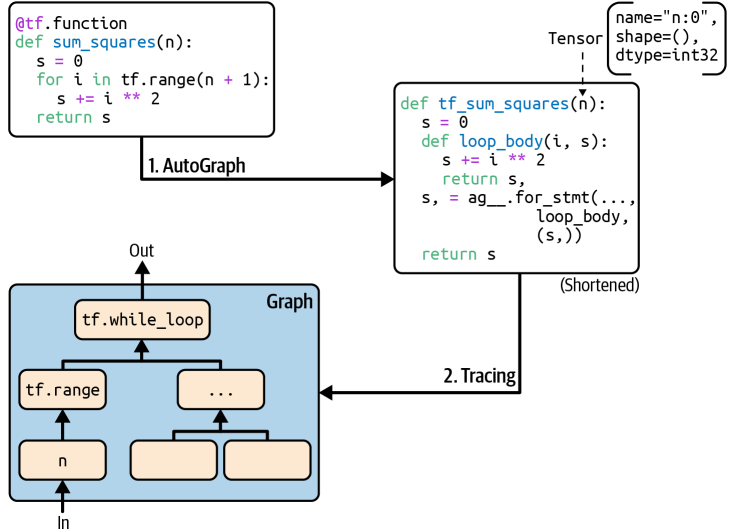

例如，在上图中，自动图分析了 sum_squares() Python函数的源代码，并生成了 tf__sum_squares() 函数。在这个函数中，for循环被 loop_body() 函数的定义（包含原始的for循环的主体）所取代，然后调用 for_stmt() 函数。此调用将在计算图中构建适当的 tf.while_loop() 操作。

为了查看生成的函数的源代码，您可以调用 **tf.autograph.to_code(sum_squares.python_function)** 。这些代码并不意味着它很漂亮，但它有时可以帮助调试。

### 4.2 TF函数规则

大多数情况下，将执行 TensorFlow 操作的Python函数转换为TF函数是很简单的：用 **@tf.function** 来装饰它。或者让Keras为你处理它。然而，也有一些规则需要尊重：

1. 如果您调用任何外部库，包括NumPy，甚至是标准库，此调用将只在跟踪期间运行；它不会是图的一部分。实际上，一个张量流图只能包括张量流构造（张量、操作、变量、数据集等）。因此，确保您使用 tf.reduce_sum() 而不是np.sum()，tf.sort() 而不是内置的 sorted() 函数，依此类推（除非您真的希望代码只在跟踪期间运行）。
2. 您可以调用其他Python函数或TF函数，但它们应该遵循相同的规则，因为TensorFlow将在计算图中捕获它们的操作。请注意，这些其他函数不需要@tf.function修饰。
3. 如果函数创建了一个 TnesorFlow 变量（或任何其他有状态的 TensorFlow 对象，如数据集或队列），它必须在第一次调用时这样做，否则您将得到一个异常。通常最好在TF函数之外创建变量（例如，在自定义层的 bulid() 方法中）。如果要为变量赋值，请确保调用其 assign() 方法，而不是使用=运算符。
4. 您的Python函数的源代码应该可用于TensorFlow。如果源代码不可用（例如，如果您在Python shell中定义函数，它不提供对源代码的访问，或者如果您只部署编译的*.pyc Python文件到生产中），那么图形生成过程将失败或具有有限的功能。
5. TensorFlow将只捕获在张量或tf.data.Dataset（请参见第13章）上迭代的循环。因此，请确保使用 for i in tf.range(x) 而不是 for i in range(x) ，否则循环将不会在图中捕获。相反，它将在跟踪期间运行。（如果for循环旨在构建图，这可能是你想要的；例如，在神经网络中创建每一层）
6. 与往常一样，出于性能原因，您应该尽可能地选择向量化实现，而不是使用循环。